In [4]:
from imports import *

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Questions

- What's the main difference between a Python list and a NumPy (or C) array? What is the main trade-off involved?
- Do array slices return a view or a copy? What can this be useful for?
- What are four methods to access and modify data in an array?
- What two features make NumPy arrays more efficient storage containers than lists?

Answers
- The overhead: Python lists are references to objects, each of which has information like type, size, memory location, etc. NumPy arrays can only store a single data type and thus don't need this extra overhead for each element. The tradeoff is flexibility vs speed: Python lists are very flexible (can store different types) but slow, NumPy arrays can only store homogenous data but are fast.
- A view, which allows you to operate on a subset of a large dataset without copying it.
- Indexing, slicing, boolean indexing, fancy indexing.
- They have less overhead (see above) and elements are stored in memory contiguously, which means they can be read faster.

## True of false?

Indexing and reshaping

In [3]:
a = np.arange(1, 10)
b = a.reshape(3, 3)
b[0, 0] = 99
a[0] == 1

False

In [4]:
a = np.arange(3)
(a.reshape(1, 3) == a[:, np.newaxis]).all()

False

Slicing

In [6]:
a = np.arange(10)
all(a[5:1:-2] == [5, 3])

True

Explanation: slicing works like `[start:stop:stride]`, with `start` being included and `stop` being excluded in the result, and with defaults being, respectively, `0`, `length of array`, and `1`. If the `stride` is negative, then the defaults for `start` and `stop` get reversed, and `start` is now the endpoint of array but will still be included (it's still the start element), and `stop` is now the start point (but, if specified, will still be ommitted).

Fancy indexing

In [32]:
a = np.array([1, 2, 3, 4, 5])
idx = [3, 2, 0]
all(a[idx] == [4, 3, 2])

False

2d fancy indexing

In [25]:
X = np.arange(12).reshape(3, 4)
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [26]:
row = np.array([1, 2])
col = np.array([2, 3])
(X[row, col] == [6, 10]).all()

False

Fancy indexing and simple indexing

In [27]:
all(X[2, [3, 2, 1]] == [11, 10, 9])

True

Fancy indexing and slicing

In [43]:
(X[1:, [1, 2]] == [[5, 6],
                  [9, 10]]).all()

True

Fancy indexing and masking

In [44]:
mask = np.array([1, 0, 1])
rows = np.array([1, 2])
(X[rows[:, np.newaxis], mask] == [[5, 4, 5], [9, 8, 9]]).all()

True

In [51]:
# what does buffering have to do with the answer? (see ?np.add.at)

x = np.zeros(3)
idx = [0, 1, 1, 1]
x[idx] += 1

y = np.zeros_like(x)
np.add.at(y, idx, 1)

(x == y).all()

False

In [54]:
x = np.array([4, 3, 1, 5, 2])
(x[np.argsort(x)] == np.sort(x)).all()

True

In [56]:
x = np.arange(1, 5)
all(x.reshape(-1, 1) == x.reshape(len(x), 1))

True

In [71]:
x = np.arange(2)
all(x.repeat(2) == np.tile(x, 2))

False

In [73]:
all(np.arange(2).repeat([1, 2]) == np.array([0, 1, 1]))

True

In [74]:
a = np.arange(5)
i = [0, 4]
a.put(i, [99, 88])
all(a.take(i) == [99, 88])

True

In [90]:
a = np.array([[10, 30],
              [70, 90]])
imax = np.expand_dims(np.argmax(a, axis=1), axis=1)
np.put_along_axis(a, imax, 99, axis=0)
(a == [[10, 30], [70, 99]]).all()

False

As exercise, replace column mins with 55.

In [99]:
a = np.arange(6).reshape(2, 3)
(a[::-1, ::-1] == [[2, 1, 0],
                   [5, 4, 3]]).all()

False

In [105]:
x = np.array([3, 1, 4, 5, 2])
all(np.partition(x, 2) == x[np.argpartition(x, 2)])

True

## Summing values

Lessons:
- NumPy methods perform best on NumPy arrays; builtins, on lists.
- `np.add.reduce()` is twice as fast as `np.sum()`

In [106]:
mylist, myrange = range(1000), np.arange(1000)

In [107]:
%timeit np.add.reduce(myrange)

1.33 µs ± 3.88 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [108]:
%timeit np.sum(myrange)

3.39 µs ± 107 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [109]:
%timeit sum(mylist)

11.6 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [110]:
%timeit functools.reduce(operator.add, mylist)

43.9 µs ± 301 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Broadcasting

First, it's helpful to know how NumPy labels dimensions. The image below makes this clear.

<img src="img/ndarray_dimensions.png" alt="Drawing" style="width: 500px;"/>

Image from [Elegant SciPy](https://www.oreilly.com/library/view/elegant-scipy/9781491922927/)

Next, let's look at how broadcasting works:

<img src="img/numpy_broadcasting.png" alt="Drawing" style="width: 500px;"/>

Image from [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/)

Determining broadcasting compatibility:
- Comparing dimensions from right to left, ignoring different number of dimensions, arrays are compatible if the dimension of either array is 1 or if they match.

### 1D

In [ ]:
# outer product of two vectors
x = np.arange(1, 5).reshape(-1, 1)
y = np.arange(2, 6).reshape(1, -1)
x * y

Explanation: `-1` automatically determines the dimension in which it occurs based on all other specified dimensions. When creating `x` above, we create an np-array of length 4 and then specify that we want a single column while specifying `-1` for the row dimension, so we end up with four rows.

### 2D

In [ ]:
a = np.arange(12).reshape(4, -1)

# demeaning columns
a - a.mean(0)

# demeaning rows
row_means = a.mean(1)
a - row_means[:, np.newaxis]

### 3D

In [ ]:
rng = np.random.default_rng(2312)
a = rng.integers(1, 10, size=24).reshape(4, 3, 2)
a

#### Taking means along a dimension

What does it mean to take the mean of the zeroth dimension? It means to "collapse" that dimension down to size 0 or to "flatten" the array in that dimension, and to take the mean of each "stack" of values that was flattened. In the image above, imagine pressing down vertically from the top of the array, flattening the zeroth dimension and ending up with a shape of (3, 2). As we do this, we take the mean of each of the 3 x 2 = 6 stacks of values that we compressed on our way down. These are the means of dimension zero. In our array `a`, the stack in the top right corner, [0, 0], is [1, 6, 6, 1], with a mean of 3.5, so the [0, 0] element of our new flattened shape is 9, as we can see below.

In [ ]:
mean0 = a.mean(0)
mean0

#### Demeaning an axis

To demean axis 0 of `a` we can now simply subtract our means from the original shape. (If we were to take the mean again, each element in the resulting (3, 2) array would be 0, so demeaning worked.)

In [ ]:
(a - mean0)

In [ ]:
(a - mean0).mean(0)

#### Broadcasting along an axis

We just did this above. The reason demeaning worked is because by broadcasting rules, our smaller (3, 2) array of means got padded in position 0 to (1, 3, 2), and then broadcasted (stretched) along the first dimension to match the (4, 3, 2) shape of `a`. Thus, to broadcast along axis 0, we need an array of shape (3, 2) or (1, 3, 2). Similarly, to broadcast along axis 1, we need an array of shape (4, 1, 2); to broadcast along axis 2, an array of shape (4, 3, 1). To practice, let's demean axis 1.

In [ ]:
a

In [ ]:
mean1 = a.mean(1)
mean1

This has shape (4, 2), which means we can't demean directly.

In [ ]:
a - mean1

Why didn't this work? The smaller (4, 2) array got padded in position 0 to (1, 4, 2), which can't be expanded to match the (4, 3, 2) shape of `a`. What we need -- and we already knew this -- is an array of shape (4, 1, 2). We can produce one by simply adding a dimension to our mean array.

In [ ]:
mean1 = mean1[:, np.newaxis, :]
mean1

Visually, in the image above, we have now separated out the two means of each of the four layers of values, and can now broadcast these along dimension 1. Another way of thinking about this is to think of each of the our layers as its own 2D shape. In that case, all we did was calculate column means by calculating means along the first axis (just as we would in a single 2D shape, except that the first axis there would be axis 0 instead of 1), and now we are broadcasting these mean values along the rows to demean the columns.

In [ ]:
a - mean1

Again, we can see that the mean of each of the 4 x 2 = 8 blocks of size 3 is 0, just as we'd expect.

Just as an exercise, let's demean axis 2, too:

In [ ]:
a - a.mean(2)[:, :, np.newaxis]

#### Setting array values

In [ ]:
arr = np.zeros((4, 3))
arr[:] = 5
arr

In [ ]:
columns = np.array([1, 2, 3, 4])
arr[:] = columns[:, np.newaxis]
arr

In [ ]:
arr[:2] = [[8],
           [9]]
arr

## Understanding `ravel()`

### Basics

- Ravel (meaning to untangle) flattens arrays.
- `ravel()` returns a one dimensional array (i.e. a list) of the values of the input array in the specified [order](https://en.wikipedia.org/wiki/Row-_and_column-major_order).
- Basically: row major order (also C order) proceeds row-wise, column major order (also Fortran order) proceeds column-wise.
- NumPy usually stores arrays in row-order, so that `ravel()` can produce a view without the need to produce a copy. If an array is stored differently (maybe because it was created from a slice), `ravel()` might have to produce a copy [first](https://numpy.org/doc/stable/user/quickstart.html#shape-manipulation).
- Especially when working with higher dimensional data, the following is a helpful reminder of how order determines the result: row major order traverses data from high to low dimensions; column major, from low to high dimensions.


In [111]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a.ravel()

array([1, 2, 3, 4, 5, 6])

Different order types

In [112]:
# (C-style) row-major order, the default
a.ravel(order='C')

array([1, 2, 3, 4, 5, 6])

In [113]:
# (Fortran-style) column-major order
a.ravel(order='F')

array([1, 4, 2, 5, 3, 6])

In [114]:
# Read as F if column-major in memory, else read as C
a.ravel(order='A')

array([1, 2, 3, 4, 5, 6])

In [115]:
# Order as layed out in memory
a.ravel(order='K')

array([1, 2, 3, 4, 5, 6])

In [116]:
(a.ravel() == a.flatten()).all() and (a.flatten() == a.reshape(-1)).all()

True

Then on to https://stackoverflow.com/questions/38143717/groupby-in-python-pandas-fast-way

In [130]:
x = np.arange(12).reshape(3, 1, 4)
x

array([[[ 0,  1,  2,  3]],

       [[ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11]]])

In [131]:
x.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [132]:
x.ravel(order='F')

array([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])

### `ravel_multi_index()`

tbd

## Fluency exercises

Code snippets are from Jake Vanderplas' Python Data Science Handbook. 

### Draw and plot a 100 points from a multivariate normal distribution and highlight a random sample of 20

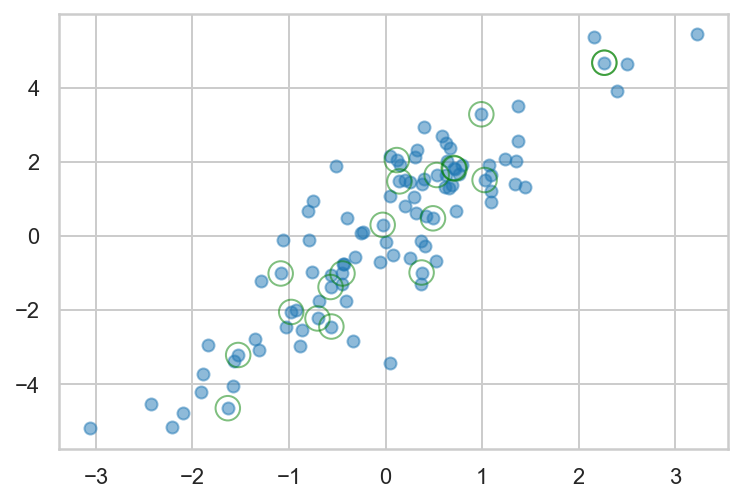

In [133]:
rng = np.random.default_rng(2312)
mean = [0, 0]
cov = [[1, 2], [2, 5]]
data = rng.multivariate_normal(mean, cov, size=100)
sample = rng.choice(data, 20)

fmt = dict(s=150, facecolor='none', edgecolor='green')
plt.scatter(data[:,0], data[:,1], alpha=0.5)
plt.scatter(sample[:,0], sample[:,1], alpha=0.5, **fmt);

### Manually draw a histogram of 1000 random values using only numpy functions and `plt.plot()`.

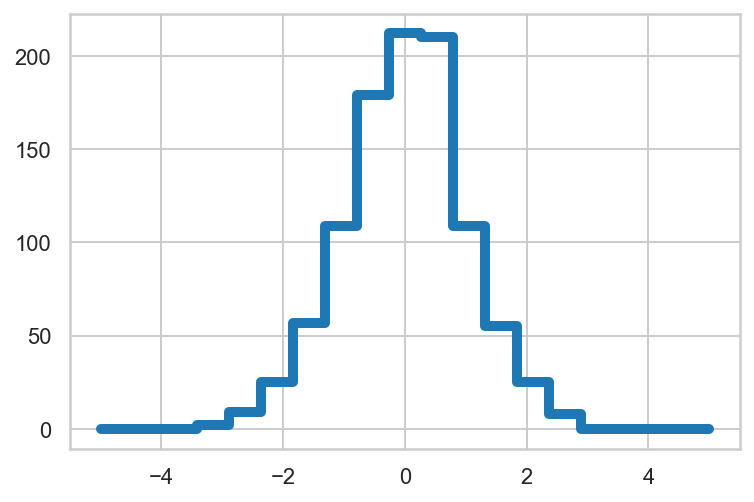

In [164]:
rng = np.random.default_rng(2312)
x = rng.normal(size=1000)

# sort data into 20 bins
bins = np.linspace(-5, 5, 20)
labels = bins.searchsorted(x)

# count observations by label
counts = np.zeros_like(bins)
np.add.at(counts, labels, 1)

plt.plot(bins, counts, drawstyle='steps', lw=5);

### Write a simple selection sort algorithm

In [2]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        x[i], x[swap] = x[swap], x[i]
    return x
    
x = np.array([1, 4, 3, 2, 5])
selection_sort(x)

array([1, 2, 3, 4, 5])

Explain in words why `a, b = b, a` works. Because of Python's evaluation order when performing value assignment, its tuple creation syntax, and tuple unpacking. When performing value assignment, Python evaluates the right-hand side first, and in this case produces the tuple `(b, a)` because two comma-separated values are evaluated as a tuple. Next, Python assigns the tuple to the the left-hand side. Because left-hand side consists of more than one element Python attempts tupe unpacking, assigning the first value of the tuple to the first element on the left-hand side, and the second element to the second.

### Use np and plt functions to calculate the k nearest neighbours of 10 random points and visualise the result

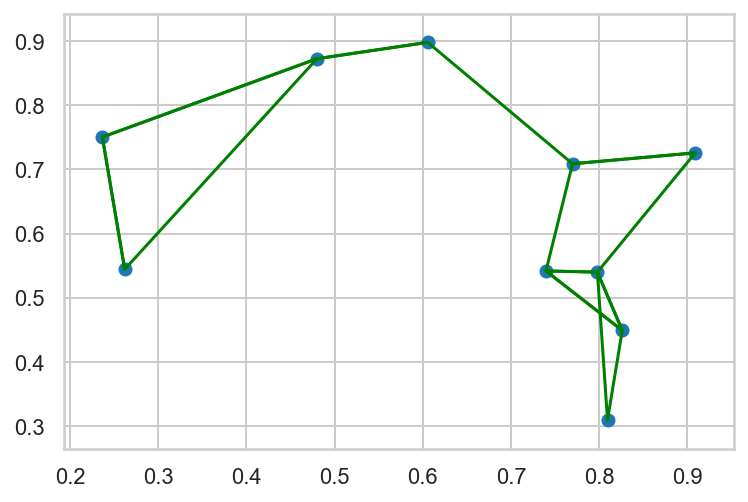

In [170]:
rng = np.random.default_rng(2312)
x = rng.random(size=(10, 2))

# calculate squared distances
squared_dist = ((x[np.newaxis, :, :] - x[:, np.newaxis, :]) ** 2).sum(-1)

# identify k nearest neighbhours
k = 2
nearest_partition = np.argpartition(squared_dist, k + 1)

# plot points and connections to nearest neighbours
plt.scatter(x[:, 0], x[:, 1])
for i in range(len(x)):
    for j in nearest_partition[i, :k + 1]:
        plt.plot(*zip(x[i], x[j]), color='green')

#### Understanding the solution

The most mind-bending bit for me is the calculation of the point-wise differences. To wrap my head around this, I start with a simple case:

In [ ]:
a = np.arange(5)
a

To get the element-wise differences for a one-dimensional array, it's easier to visualise what to do: turn the array into a column and row vector and then use broadcasting to calculate each of the differences (broadcasting will expand each of the vectors into a 5x5 matrix, and then perform element-wise matrix subtraction).

In [ ]:
diffs = a[:, np.newaxis] - a[np.newaxis, :]
diffs

From here, we can then square the values and retrieve the nearest neighbour for each element of the original array:

In [ ]:
k = 2
squared_diffs = diffs ** 2
nearest_partition = np.argpartition(squared_diffs, k + 1, axis=1)
nearest_partition

I still occasionally get tripped up when interpreting the above: focusing on the first row, the first element, 1, says that in the partitioned array, element 1 from the `squared_diffs` array will be in position zero. The next element, 0, says that element zero from `squared_diffs` will be in position one, and so on. With this, we can now extract the k nearest neighbours for each element in our original array.

In [ ]:
for i in range(len(a)):
    neighbours = []
    for j in nearest_partition[i, :k + 1]:
        if a[j] != a[i]:
            neighbours.append(a[j])
    print(a[i], neighbours)

To understand how to find nearest neighbouts in three dimensions, let's start with a toy example.

In [ ]:
a = np.arange(4).reshape(2, 2)
a

Intuitively, what we want to do is build two cubes -- one built from the original array broadcasted vertically and one from the original array flipped on one of its edges and then broadcasted horizontally -- and then perform element-wise subtraction. Or, more acurately, we want to create arrays such that broadcasting builds appropriate cubes for us before it performs the element-wise subtraction. But for intuitions sake, let's build the cubes ourselves, so we can see what happens.

In [ ]:
# broadcast array vertically (i.e. add additional layer on top of original)
vertical_cube = np.broadcast_to(a[np.newaxis, :, :], (2, 2, 2))
vertical_cube

In [ ]:
# flip array on its (0, 1) edge and stretch horizontally
horizontal_cube = np.broadcast_to(a[:, np.newaxis, :], (2, 2, 2))
horizontal_cube

In [ ]:
a[:, None, :] - a[:, :, None]

We can now do the same for our original array.

In [ ]:
x

In [ ]:
# Add a new zeroth dimension, to get shape (1, 10, 2)

x[np.newaxis, :, :]

In [ ]:
# Add a new first dimension, to flip the array on its upper edge and create a (10, 1, 2) shape

x[:, np.newaxis, :]

When we subtract the second from the first array, broadcasting will expand both arrays to shape (10, 10, 2), thus building our vertical (from the first array) and horizontal (from the second array) cubes on which it then performs element-wise subtraction. (We didn't actually need to create the new zeroth dimension in our first array, because broadcasting pads the shorter array with new dimensions on the left and would thus perform this step for us.) The result is what we want: the difference in each dimension for each of the ten points to all of the ten points. Once we have this, we can square the values and sum them along dimension 2 (the last dimension, hence the use of -1 in the code above), which gives us the distances between the points.

In [ ]:
x[np.newaxis, :, :] - x[:, np.newaxis, :]

### Find index of values in array

I want to find a list of indices representing the index of each row of one array in another array (From [here](https://stackoverflow.com/questions/38674027/find-the-row-indexes-of-several-values-in-a-numpy-array)).

In [171]:
x = np.array([[4,  2],
              [9,  3],
              [8,  5],
              [3,  3],
              [5,  6]])

tofind = np.array([[4, 2],
                   [3, 3],
                   [5, 6]])

# desired result: [0, 3, 4]

In [ ]:
# approach 1: loop

result = []
for a in tofind:
    i = np.argwhere([((x - a) == 0).all(1)])[0][1]
    result.append(i)
result

In [ ]:
# approach 2: broadcasting
np.where((x == tofind[:, np.newaxis]).all(-1))[1]

## Sources
- [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/)
- [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)
- [Elegant SciPy](https://www.oreilly.com/library/view/elegant-scipy/9781491922927/)